# Diet Type Classification

## Import Packages

In [94]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [95]:
diet_data = pd.read_csv('../data/All_Diets.csv')
print(f"Shape of the dataset: {diet_data.shape}")
diet_data.head()

Shape of the dataset: (7806, 8)


Diet_type                                        Recipe_name  \
0     paleo                    Bone Broth From 'Nom Nom Paleo'   
1     paleo  Paleo Effect Asian-Glazed Pork Sides, A Sweet ...   
2     paleo                                  Paleo Pumpkin Pie   
3     paleo                       Strawberry Guacamole recipes   
4     paleo  Asian Cauliflower Fried "Rice" From 'Nom Nom P...   

       Cuisine_type  Protein(g)  Carbs(g)  Fat(g) Extraction_day  \
0          american        5.22      1.29    3.20     2022-10-16   
1  south east asian      181.55     28.62  146.14     2022-10-16   
2          american       30.91    302.59   96.76     2022-10-16   
3           mexican        9.62     75.78   59.89     2022-10-16   
4           chinese       39.84     54.08   71.55     2022-10-16   

  Extraction_time  
0        17:20:09  
1        17:20:09  
2        17:20:09  
3        17:20:09  
4        17:20:09

## Dataset Exploration (MS2)

Total Number of Observations: 7806

Number of Attributes: 6

| Attribute | Explanation |
|-----------|-------------|
|**Diet_type** | The type of diet the recipe fits into. |
| **Recipe_name**| The name of the recipe.|
| **Cuisine_type**| The type of cuisine the recipe belongs to. |
| **Protein(g)**| The amount of protein in the recipe, measured in grams. |
| **Carbs(g)**| The amount of carbohydrates in the recipe, measured in grams. |
| **Fat(g)**| The amount of fat in the recipe, measured in grams. |
| **Extraction_day**| The day the data was extracted. |
| **Extraction_time**| The time the data was extracted. |

In [96]:
diet_data.describe().round(2)

Protein(g)  Carbs(g)   Fat(g)
count     7806.00   7806.00  7806.00
mean        83.23    152.12   117.33
std         89.80    185.91   122.10
min          0.00      0.06     0.00
25%         24.42     36.16    41.07
50%         56.28     93.42    84.86
75%        112.36    205.92   158.29
max       1273.61   3405.55  1930.24

In [97]:
diet_types = diet_data['Diet_type'].unique()
print(diet_types)

['paleo' 'vegan' 'keto' 'mediterranean' 'dash']


In [98]:
cuisine_types = diet_data['Cuisine_type'].unique()
print(cuisine_types)

['american' 'south east asian' 'mexican' 'chinese' 'mediterranean'
 'italian' 'french' 'indian' 'nordic' 'eastern europe' 'central europe'
 'kosher' 'british' 'caribbean' 'south american' 'middle eastern' 'asian'
 'japanese' 'world']


In [99]:
null_counts = diet_data.isnull().sum()
print(null_counts)

Diet_type          0
Recipe_name        0
Cuisine_type       0
Protein(g)         0
Carbs(g)           0
Fat(g)             0
Extraction_day     0
Extraction_time    0
dtype: int64


In [100]:
diet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Diet_type        7806 non-null   object 
 1   Recipe_name      7806 non-null   object 
 2   Cuisine_type     7806 non-null   object 
 3   Protein(g)       7806 non-null   float64
 4   Carbs(g)         7806 non-null   float64
 5   Fat(g)           7806 non-null   float64
 6   Extraction_day   7806 non-null   object 
 7   Extraction_time  7806 non-null   object 
dtypes: float64(3), object(5)
memory usage: 488.0+ KB


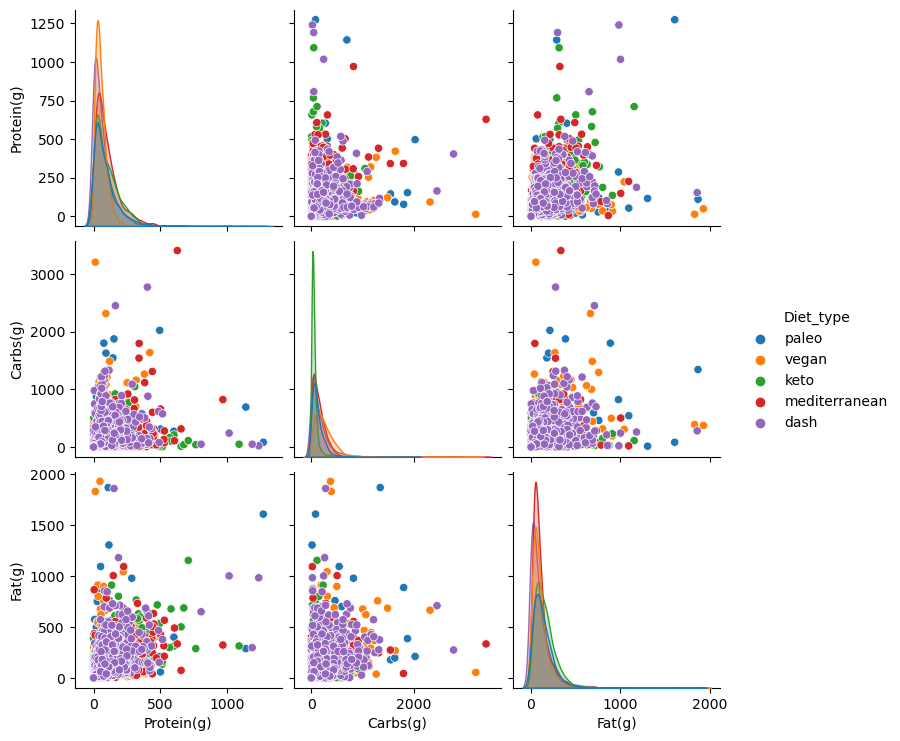

In [101]:
sns.pairplot(diet_data, hue='Diet_type', diag_kind='kde')

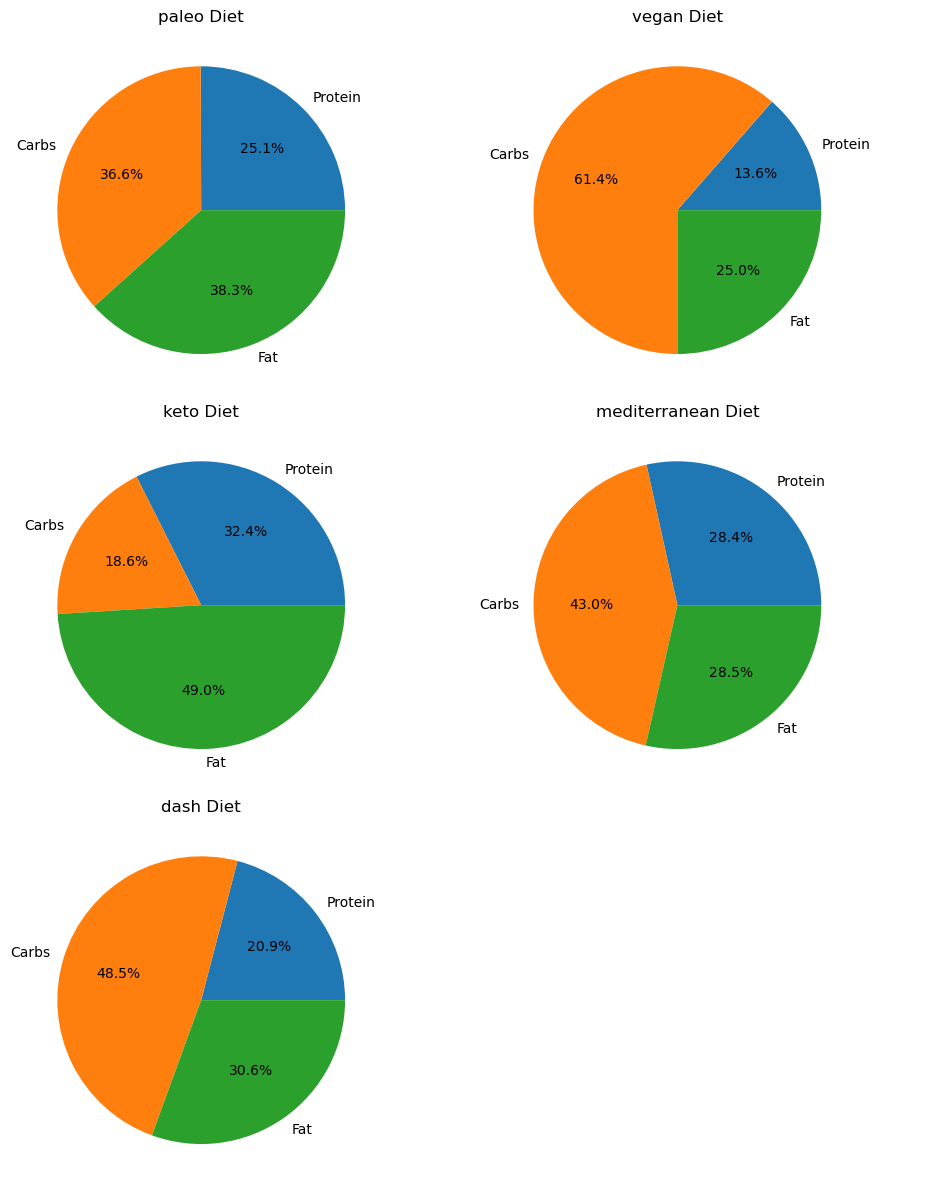

In [102]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()
for i, diet_type in enumerate(diet_data['Diet_type'].unique()):
    df_grouped = diet_data[diet_data['Diet_type'] == diet_type]
    axes[i].pie(df_grouped[['Protein(g)','Carbs(g)','Fat(g)']].sum(), labels=['Protein', 'Carbs', 'Fat'], autopct='%1.1f%%')
    axes[i].set_title(f'{diet_type} Diet')
axes[5].axis('off')
# Adjust layout and display
plt.tight_layout()
plt.show()

# Pre-Processing (MS3)

### Clean Up

In [103]:
diet_data = diet_data.rename(
    columns={
        'Diet_type': 'Diet',
        'Recipe_name': 'Recipe',
        'Cuisine_type': 'Cuisine',
        'Protein(g)': 'Protein',
        'Carbs(g)': 'Carbs',
        'Fat(g)': 'Fat',
        })
print(diet_data.columns)

Index(['Diet', 'Recipe', 'Cuisine', 'Protein', 'Carbs', 'Fat',
       'Extraction_day', 'Extraction_time'],
      dtype='object')


### Drop `Extraction Date` and `Extraction Time`

In [104]:
dd_processed = diet_data.drop(columns=['Extraction_day', 'Extraction_time'])
dd_processed.head()

Diet                                             Recipe           Cuisine  \
0  paleo                    Bone Broth From 'Nom Nom Paleo'          american   
1  paleo  Paleo Effect Asian-Glazed Pork Sides, A Sweet ...  south east asian   
2  paleo                                  Paleo Pumpkin Pie          american   
3  paleo                       Strawberry Guacamole recipes           mexican   
4  paleo  Asian Cauliflower Fried "Rice" From 'Nom Nom P...           chinese   

   Protein   Carbs     Fat  
0     5.22    1.29    3.20  
1   181.55   28.62  146.14  
2    30.91  302.59   96.76  
3     9.62   75.78   59.89  
4    39.84   54.08   71.55

### Encoding

In [105]:
encoder = LabelEncoder()

# Encode Diet Type & Cuisine Type
dd_processed['Diet'] = encoder.fit_transform(dd_processed['Diet'])
dd_processed = pd.get_dummies(dd_processed, columns=['Cuisine'])

dd_processed.head()

Diet                                             Recipe  Protein   Carbs  \
0     3                    Bone Broth From 'Nom Nom Paleo'     5.22    1.29   
1     3  Paleo Effect Asian-Glazed Pork Sides, A Sweet ...   181.55   28.62   
2     3                                  Paleo Pumpkin Pie    30.91  302.59   
3     3                       Strawberry Guacamole recipes     9.62   75.78   
4     3  Asian Cauliflower Fried "Rice" From 'Nom Nom P...    39.84   54.08   

      Fat  Cuisine_american  Cuisine_asian  Cuisine_british  \
0    3.20              True          False            False   
1  146.14             False          False            False   
2   96.76              True          False            False   
3   59.89             False          False            False   
4   71.55             False          False            False   

   Cuisine_caribbean  Cuisine_central europe  ...  Cuisine_italian  \
0              False                   False  ...            False   
1              False                   False  ...            False   
2              False                   False  ...            False   
3              False                   False  ...            False   
4              False                   False  ...            False   

   Cuisine_japanese  Cuisine_kosher  Cuisine_mediterranean  Cuisine_mexican  \
0             False           False                  False            False   
1             False           False                  False            False   
2             False           False                  False            False   
3             False           False                  False             True   
4             False           False                  False            False   

   Cuisine_middle eastern  Cuisine_nordic  Cuisine_south american  \
0                   False           False                   False   
1                   False           False                   False   
2                   False           False                   False   
3                   False           False                   False   
4                   False           False                   False   

   Cuisine_south east asian  Cuisine_world  
0                     False          False  
1                      True          False  
2                     False          False  
3                     False          False  
4                     False          False  

[5 rows x 24 columns]

### Data Splitting

In [106]:
X = dd_processed.drop(columns=['Recipe','Diet'])
y = dd_processed['Diet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# validation test
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Scaling

In [107]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_val = scaler.transform(X_train_val)
X_test_val = scaler.transform(X_test_val)

### Training Our First Model

In [108]:
# We are starting with a simple Logistic Regression to get a baseline performance
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)
y_pred_val = logreg.predict(X_test_val)

logreg_training_accuracy = accuracy_score(y_train, y_pred_train)
logreg_test_accuracy = accuracy_score(y_test, y_pred_test)
logreg_validation_accuracy = accuracy_score(y_test_val, y_pred_val)

print(f"Training Accuracy: {logreg_training_accuracy:.4f}")
print(f"Test Accuracy: {logreg_test_accuracy:.4f}")
print(f"Validation Accuracy: {logreg_validation_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

Training Accuracy: 0.5452
Test Accuracy: 0.5378
Validation Accuracy: 0.5388

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.32      0.37       348
           1       0.49      0.79      0.61       303
           2       0.71      0.75      0.73       361
           3       0.34      0.11      0.16       253
           4       0.52      0.64      0.58       297

    accuracy                           0.54      1562
   macro avg       0.50      0.52      0.49      1562
weighted avg       0.51      0.54      0.51      1562



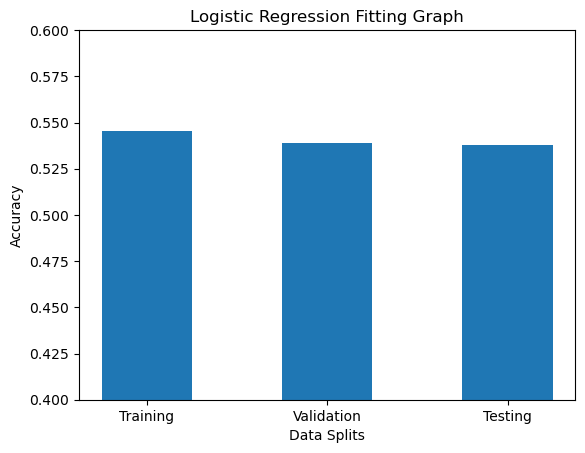

In [109]:
categories = ['Training','Validation', 'Testing']
logreg_accuracies = [logreg_training_accuracy, logreg_validation_accuracy, logreg_test_accuracy]

x = np.arange(len(categories))
width = 0.5
fig, ax = plt.subplots()
bars = ax.bar(x, logreg_accuracies, width)

# scale it from 0.4 to 0.6 to see the differences between the accuracies better
plt.ylim([0.4, 0.6])
ax.set_xlabel('Data Splits')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Fitting Graph')
ax.set_xticks(x)
ax.set_xticklabels(categories);

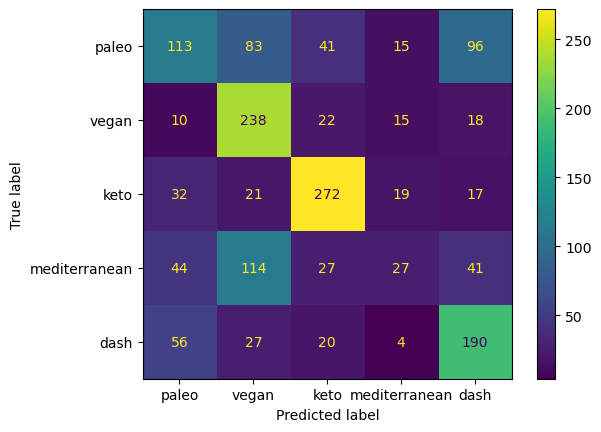


Class  dash
True Positives:  113
False Positives:  142
True Negative:  1072
False Negative:  235

Class  keto
True Positives:  238
False Positives:  245
True Negative:  1014
False Negative:  65

Class  mediterranean
True Positives:  272
False Positives:  110
True Negative:  1091
False Negative:  89

Class  paleo
True Positives:  27
False Positives:  53
True Negative:  1256
False Negative:  226

Class  vegan
True Positives:  190
False Positives:  172
True Negative:  1093
False Negative:  107


In [110]:
class_label = encoder.inverse_transform(np.unique(y_test))
logreg_confusion = confusion_matrix(y_test, y_pred_test, labels= np.unique(y_test))
logreg_graph = ConfusionMatrixDisplay(confusion_matrix=logreg_confusion, display_labels=diet_types)

logreg_graph.plot()
plt.show()
for i in range(len(np.unique(y_test))):
    tp = logreg_confusion[i, i]
    fp = logreg_confusion.sum(axis=0)[i] - tp
    fn = logreg_confusion.sum(axis=1)[i] - tp
    tn = logreg_confusion.sum() - (tp + fp + fn)
    print("\nClass ", class_label[i])
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("True Negative: ", tn)
    print("False Negative: ", fn)

# Second Model  (MS4)

In [111]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)

# Predictions
y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
y_pred_val = svc.predict(X_test_val)

svc_training_accuracy = accuracy_score(y_train, y_pred_train)
svc_test_accuracy = accuracy_score(y_test, y_pred_test)
svc_validation_accuracy = accuracy_score(y_test_val, y_pred_val)

print(f"Training Accuracy: {svc_training_accuracy:.4f}")
print(f"Test Accuracy: {svc_test_accuracy:.4f}")
print(f"Validation Accuracy: {svc_validation_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

Training Accuracy: 0.5852
Test Accuracy: 0.5589
Validation Accuracy: 0.5701

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.39      0.43       348
           1       0.56      0.73      0.63       303
           2       0.70      0.77      0.73       361
           3       0.33      0.19      0.24       253
           4       0.55      0.65      0.60       297

    accuracy                           0.56      1562
   macro avg       0.53      0.54      0.53      1562
weighted avg       0.54      0.56      0.54      1562



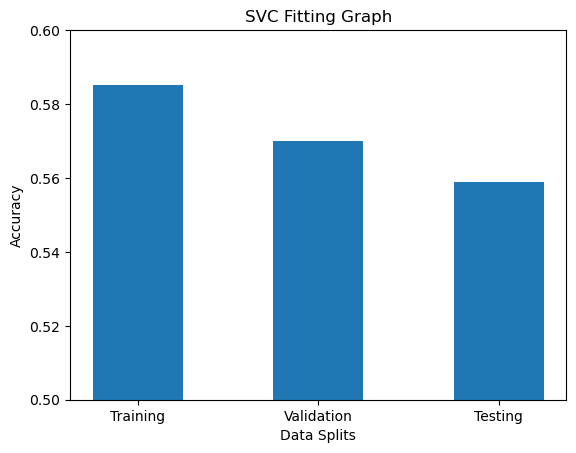

In [112]:
categories = ['Training','Validation', 'Testing']
svc_accuracies = [svc_training_accuracy, svc_validation_accuracy, svc_test_accuracy]

x = np.arange(len(categories))
width = 0.5
fig, ax = plt.subplots()
bars = ax.bar(x, svc_accuracies, width)

# scale it from 0.5 to 0.6 to see the differences between the accuracies better
plt.ylim([0.5, 0.6])
ax.set_xlabel('Data Splits')
ax.set_ylabel('Accuracy')
ax.set_title('SVC Fitting Graph')
ax.set_xticks(x)
ax.set_xticklabels(categories);

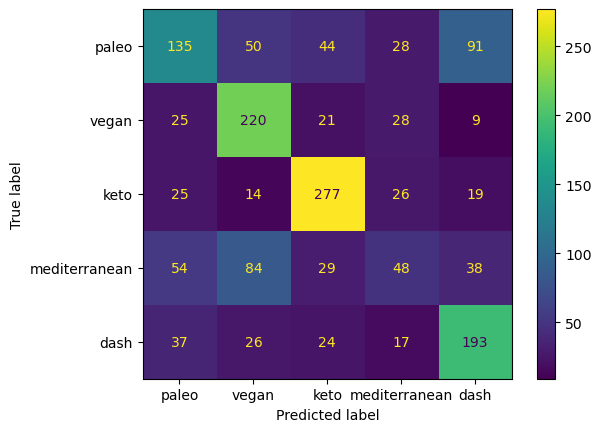


Class  dash
True Positives:  135
False Positives:  141
True Negative:  1073
False Negative:  213

Class  keto
True Positives:  220
False Positives:  174
True Negative:  1085
False Negative:  83

Class  mediterranean
True Positives:  277
False Positives:  118
True Negative:  1083
False Negative:  84

Class  paleo
True Positives:  48
False Positives:  99
True Negative:  1210
False Negative:  205

Class  vegan
True Positives:  193
False Positives:  157
True Negative:  1108
False Negative:  104


In [113]:
svc_confusion = confusion_matrix(y_test, y_pred_test, labels= np.unique(y_test))
svc_graph = ConfusionMatrixDisplay(confusion_matrix=svc_confusion, display_labels=diet_types)

svc_graph.plot()
plt.show()
for i in range(len(np.unique(y_test))):
    tp = svc_confusion[i, i]
    fp = svc_confusion.sum(axis=0)[i] - tp
    fn = svc_confusion.sum(axis=1)[i] - tp
    tn = svc_confusion.sum() - (tp + fp + fn)
    print("\nClass ", class_label[i])
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("True Negative: ", tn)
    print("False Negative: ", fn)

# Third Model

In [114]:
# another model: GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, validation_fraction=0.1, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [115]:
gb_model.score(X_test, y_test)
gb_model.score(X_test_val, y_test_val)

# Predictions
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)
y_pred_val = gb_model.predict(X_test_val)

gb_training_accuracy = accuracy_score(y_train, y_pred_train)
gb_test_accuracy = accuracy_score(y_test, y_pred_test)
gb_validation_accuracy = accuracy_score(y_test_val, y_pred_val)

print(f"Training Accuracy: {gb_training_accuracy:.4f}")
print(f"Test Accuracy: {gb_test_accuracy:.4f}")
print(f"Validation Accuracy: {gb_validation_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

Training Accuracy: 0.7534
Test Accuracy: 0.5653
Validation Accuracy: 0.7454

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.45      0.48       348
           1       0.58      0.70      0.63       303
           2       0.70      0.76      0.73       361
           3       0.36      0.26      0.30       253
           4       0.54      0.58      0.56       297

    accuracy                           0.57      1562
   macro avg       0.54      0.55      0.54      1562
weighted avg       0.55      0.57      0.55      1562



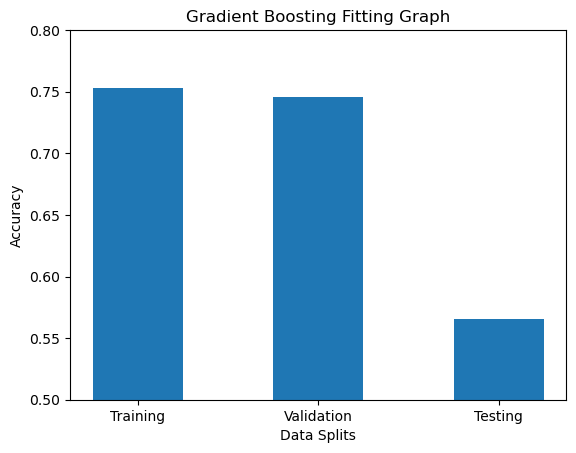

In [116]:
categories = ['Training','Validation', 'Testing']
gb_accuracies = [gb_training_accuracy, gb_validation_accuracy, gb_test_accuracy]

x = np.arange(len(categories))
width = 0.5
fig, ax = plt.subplots()
bars = ax.bar(x, gb_accuracies, width)

# scale it from 0.5 to 0.8 to see the differences between the accuracies better
plt.ylim([0.5, 0.8])
ax.set_xlabel('Data Splits')
ax.set_ylabel('Accuracy')
ax.set_title('Gradient Boosting Fitting Graph')
ax.set_xticks(x)
ax.set_xticklabels(categories);

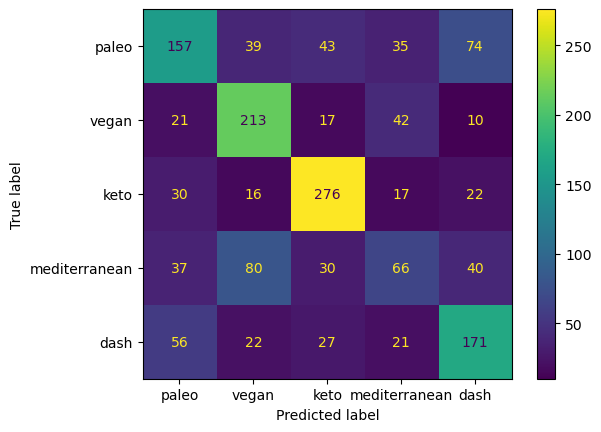


Class  dash
True Positives:  157
False Positives:  144
True Negative:  1070
False Negative:  191

Class  keto
True Positives:  213
False Positives:  157
True Negative:  1102
False Negative:  90

Class  mediterranean
True Positives:  276
False Positives:  117
True Negative:  1084
False Negative:  85

Class  paleo
True Positives:  66
False Positives:  115
True Negative:  1194
False Negative:  187

Class  vegan
True Positives:  171
False Positives:  146
True Negative:  1119
False Negative:  126


In [117]:
gb_confusion = confusion_matrix(y_test, y_pred_test, labels= np.unique(y_test))
gb_graph = ConfusionMatrixDisplay(confusion_matrix=gb_confusion, display_labels=diet_types)

gb_graph.plot()
plt.show()
for i in range(len(np.unique(y_test))):
    tp = gb_confusion[i, i]
    fp = gb_confusion.sum(axis=0)[i] - tp
    fn = gb_confusion.sum(axis=1)[i] - tp
    tn = gb_confusion.sum() - (tp + fp + fn)
    print("\nClass ", class_label[i])
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("True Negative: ", tn)
    print("False Negative: ", fn)